# Induction
Context - A superstore is planning for the year-end sale. They want to launch a new offer - gold membership, that gives a 20% discount on all purchases, for only 499$ which is 999 on other days. It will be valid only for existing customers and the campaign through phone calls is currently being planned for them. The management feels that the best way to reduce the cost of the campaign is to make a predictive model which will classify customers who might purchase the offer.


Objective - The superstore wants to predict the likelihood of the customer giving a positive response and wants to identify the different factors which affect the customer's response. You need to analyze the data provided to identify these factors and then build a prediction model to predict the probability of a customer will give a positive response.

Dataset link: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

# Data dictionary

1. Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
2. ID - Unique ID of each customer
3. Year_Birth - Age of the customer
4. Complain - 1 if the customer complained in the last 2 years
5. Dt_Customer - date of customer's enrollment with the company
6. Education - customer's level of education
7. Marital - customer's marital status
8. Kidhome - number of small children in customer's household
9. Teenhome - number of teenagers in customer's household
10. Income - customer's yearly household income
11. MntFishProducts - the amount spent on fish products in the last 2 years
12. MntMeatProducts - the amount spent on meat products in the last 2 years
13. MntFruits - the amount spent on fruits products in the last 2 years
14. MntSweetProducts - amount spent on sweet products in the last 2 years
15. MntWines - the amount spent on wine products in the last 2 years
16. MntGoldProds - the amount spent on gold products in the last 2 years
17. NumDealsPurchases - number of purchases made with discount
18. NumCatalogPurchases - number of purchases made using catalog (buying goods to be shipped through the mail)
19. NumStorePurchases - number of purchases made directly in stores
20. NumWebPurchases - number of purchases made through the company's website
21. NumWebVisitsMonth - number of visits to company's website in the last month
22. Recency - number of days since the last purchase

## Imports

In [183]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump

# Sklearn imports
from sklearn.model_selection import train_test_split

# Preprocessing imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Hyperparameters tuning
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Sampling
from imblearn.over_sampling import RandomOverSampler

# Functions

In [184]:
def format_data(data):
    """
    Converts object type columns into numerical columns,
    creates columns year, month, day,
    drops column date.
    """
    # Date formatting
    data["Day"] = data["Dt_Customer"].dt.day
    data["Year"] = data["Dt_Customer"].dt.year
    data["Month"] = data["Dt_Customer"].dt.month
    data.drop("Dt_Customer", axis = 1, inplace = True)

    # Transforming object data into numerical and filling NA in income
    # Old way
#     one_hot = OneHotEncoder()
#     simple_imputer = SimpleImputer(strategy = "median")
#     numeric_cols = ["Income"]
#     categoric_cols = ["Education", "Marital_Status"]
#     transformer = ColumnTransformer([
#         ("one_hot", one_hot, categoric_cols),
#         ("imputer", simple_imputer, numeric_cols)
#     ], remainder = "passthrough")
#    data = transformer.fit_transform(data)
    # New way
    data["Income"] = data["Income"].fillna(data["Income"].median())
    categoric_cols = ["Education", "Marital_Status"]
    for category in categoric_cols:
        data[category] = LabelEncoder().fit_transform(data[category])


    return data

In [185]:
def evaluate_model(model_dictionary, x_train, y_train, x_test, y_test):
    """
    Trains, fits and evaluates each model in passed model dictionary.
    Creates model classification report.
    Creates crosstab with answers.
    """
    for name, model in model_dictionary.items():
        print("----------------------------------------------------------------------")
        print(f"Processing: {name}...")
        model.fit(x_train, y_train)
        print(f"Score on training data: {model.score(x_train, y_train)}")
        print(f"Score on valid data: {model.score(x_test, y_test)}")
        y_preds = model.predict(x_test)
        print(f"Classification report:\n{classification_report(y_test, y_preds)}")
        ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
        plt.title("Heatmap")
        plt.show()
        print("----------------------------------------------------------------------\n")
    
    return model_dictionary

In [186]:
def save_model(model, name):
    """
    Saves model in current directory with the provided name.
    """
    dump(model, open(f"{name}ClassificationModel.pkl", "wb"))

## Importing data and data exploration

In [187]:
customers_data = pd.read_csv("superstore_data.csv")
customers_data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [188]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Quick note

Because we have got the data with datetime object we need to reload it using pandas datetime parser.

In [189]:
customers_data = pd.read_csv("superstore_data.csv",
                             parse_dates = ["Dt_Customer"])
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

In [190]:
customers_data.describe()

,Id,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107,0.009375
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274,0.096391
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000


In [191]:
customers_data.isna().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

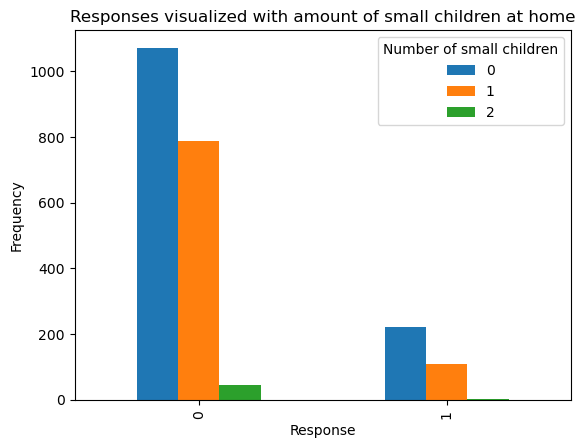

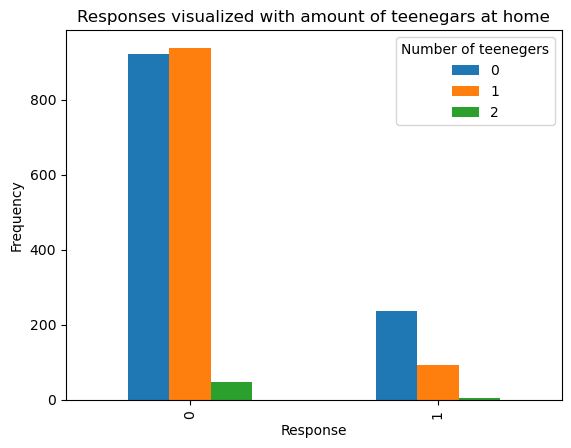

In [192]:
pd.crosstab(customers_data.Response, customers_data.Kidhome).plot(kind = "bar",
                                                                  ylabel = "Frequency")
plt.legend(title = "Number of small children")
plt.title("Responses visualized with amount of small children at home")

pd.crosstab(customers_data.Response, customers_data.Teenhome).plot(kind = "bar",
                                                                   ylabel = "Frequency")
plt.legend(title = "Number of teenegers")
plt.title("Responses visualized with amount of teenegars at home")

plt.show();

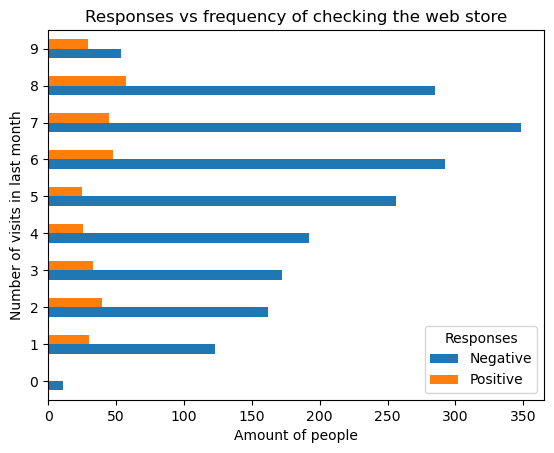

In [193]:
pd.crosstab(customers_data.NumWebVisitsMonth[customers_data.NumWebVisitsMonth < 10], customers_data.Response).plot(kind = "barh",
                                                                                                                   ylabel = "Number of visits in last month",
                                                                                                                   xlabel = "Amount of people")
plt.legend(["Negative", "Positive"],
           title = "Responses");
plt.title("Responses vs frequency of checking the web store");

C:\Users\Młody\AppData\Local\Temp\ipykernel_10316\2671745865.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(x = customers_data.NumDealsPurchases[customers_data.Response == 0][:100],
C:\Users\Młody\AppData\Local\Temp\ipykernel_10316\2671745865.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y = customers_data.Income[customers_data.Response == 0][:100],
C:\Users\Młody\AppData\Local\Temp\ipykernel_10316\2671745865.py:7: FutureWarning: The behavior of `series[i:j

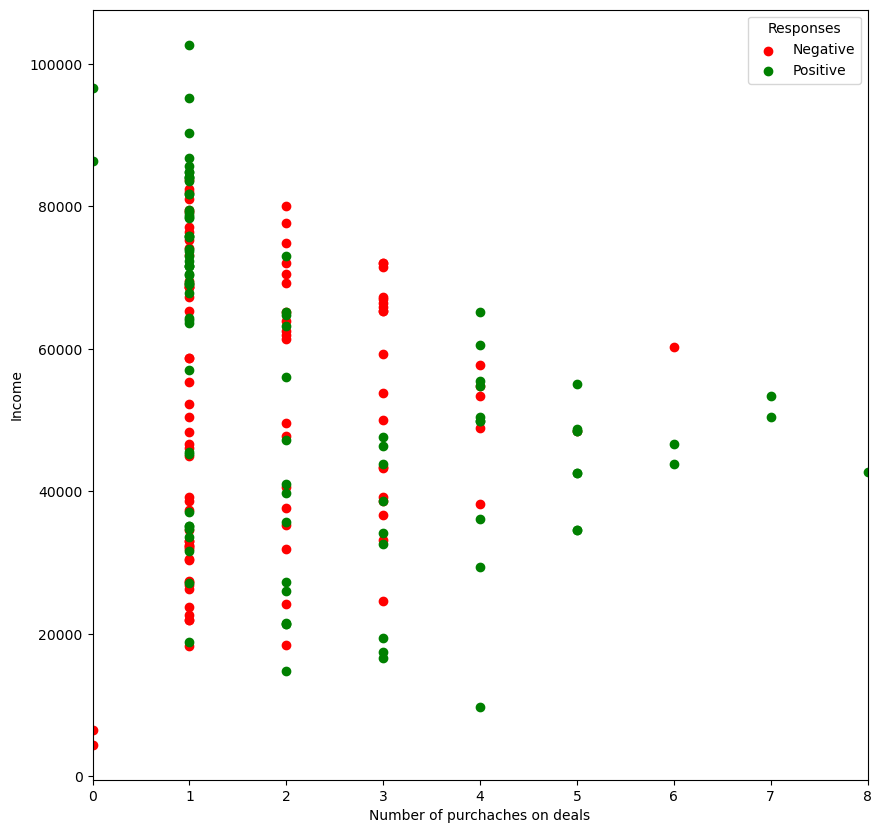

In [208]:
plt.figure(figsize = (10, 10))
plt.xlim((0, 8))
plt.scatter(x = customers_data.NumDealsPurchases[customers_data.Response == 0][:100],
            y = customers_data.Income[customers_data.Response == 0][:100],
            c = "red",)

plt.scatter(x = customers_data.NumDealsPurchases[customers_data.Response == 1][:100],
            y = customers_data.Income[customers_data.Response == 1][:100],
            c = "green",)

plt.ylabel("Income")
plt.xlabel("Number of purchaches on deals")
plt.legend(["Negative", "Positive"],
           title = "Responses");

# Modelling

In [195]:
X = customers_data.drop("Response", axis = 1)
y = customers_data["Response"]
np.random.seed(42)
df_temp = X
df_temp = df_temp.sample(frac = 1)
df_temp

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain
324,8779,1985,2n Cycle,Married,36145.0,1,0,2013-06-16,13,56,...,76,17,1,18,4,4,1,3,9,0
96,6183,1962,Master,Married,58646.0,0,1,2013-10-06,3,62,...,44,6,5,22,1,2,1,4,4,0
2104,6988,1986,Graduation,Married,71952.0,1,0,2013-10-01,93,656,...,455,52,107,93,2,8,4,8,4,0
1259,10448,1956,Graduation,Single,46998.0,0,1,2012-10-22,55,172,...,86,45,6,27,5,5,3,5,7,0
1061,524,1966,Basic,Together,22634.0,0,0,2013-01-16,47,2,...,11,8,6,46,1,2,1,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,10686,1965,PhD,Together,34230.0,1,1,2012-12-26,72,15,...,4,0,0,2,1,1,0,2,7,0
1095,9423,1979,Master,Married,32765.0,1,0,2014-02-23,49,13,...,17,7,3,3,2,2,0,4,5,0
1130,11096,1952,2n Cycle,Together,57247.0,0,1,2013-08-08,50,99,...,32,37,54,6,2,2,1,7,2,0
1294,10319,1971,Graduation,Married,66303.0,0,1,2013-02-26,56,1090,...,96,16,12,60,4,3,4,11,8,0


In [196]:
df_temp = format_data(df_temp)
df_temp

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,...,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Day,Year,Month
324,8779,1985,0,3,36145.0,1,0,13,56,4,...,18,4,4,1,3,9,0,16,2013,6
96,6183,1962,3,3,58646.0,0,1,3,62,1,...,22,1,2,1,4,4,0,6,2013,10
2104,6988,1986,2,3,71952.0,1,0,93,656,80,...,93,2,8,4,8,4,0,1,2013,10
1259,10448,1956,2,4,46998.0,0,1,55,172,41,...,27,5,5,3,5,7,0,22,2012,10
1061,524,1966,1,5,22634.0,0,0,47,2,23,...,46,1,2,1,2,8,0,16,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,10686,1965,4,5,34230.0,1,1,72,15,0,...,2,1,1,0,2,7,0,26,2012,12
1095,9423,1979,3,3,32765.0,1,0,49,13,3,...,3,2,2,0,4,5,0,23,2014,2
1130,11096,1952,0,5,57247.0,0,1,50,99,4,...,6,2,2,1,7,2,0,8,2013,8
1294,10319,1971,2,3,66303.0,0,1,56,1090,12,...,60,4,3,4,11,8,0,26,2013,2


In [197]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(df_temp, y, test_size=0.2)

### Models dictionary

In [198]:
models_dict = {
    "Logistic Regression": LogisticRegression(max_iter = 5000),
    "RandomForestClassifier": RandomForestClassifier(),
    "LinearSVC": LinearSVC(),
    "SVC": SVC(max_iter = 10000),
    "Neighbours": KNeighborsClassifier(),
    "SGD": SGDClassifier(),
    "DecisionTree": DecisionTreeClassifier()
}

----------------------------------------------------------------------
Processing: Logistic Regression...
Score on training data: 0.8537946428571429
Score on valid data: 0.8392857142857143
Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       376
           1       0.00      0.00      0.00        72

    accuracy                           0.84       448
   macro avg       0.42      0.50      0.46       448
weighted avg       0.70      0.84      0.77       448



D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


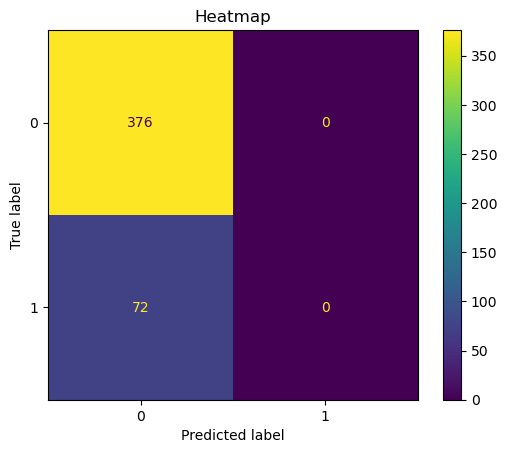

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: RandomForestClassifier...
Score on training data: 1.0
Score on valid data: 0.828125
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       376
           1       0.14      0.01      0.03        72

    accuracy                           0.83       448
   macro avg       0.49      0.50      0.47       448
weighted avg       0.73      0.83      0.76       448



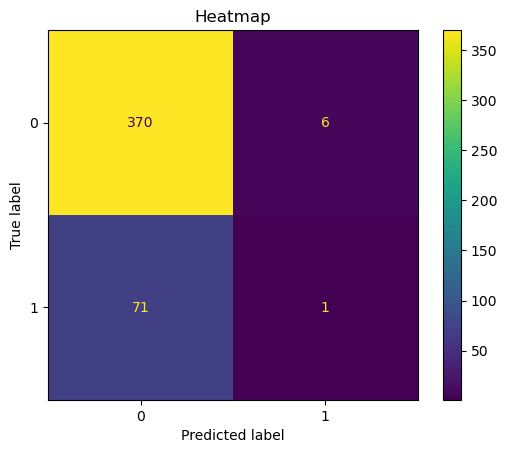

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: LinearSVC...
Score on training data: 0.8537946428571429
Score on valid data: 0.8392857142857143
Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       376
           1       0.00      0.00      0.00        72

    accuracy                           0.84       448
   macro avg       0.42      0.50      0.46       448
weighted avg       0.70      0.84      0.77       448



D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-sc

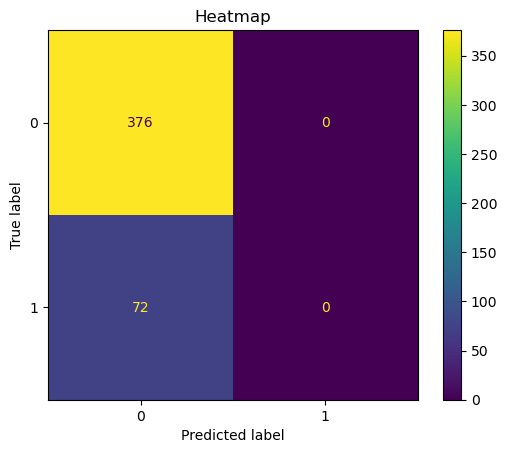

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: SVC...
Score on training data: 0.8543526785714286
Score on valid data: 0.8392857142857143
Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       376
           1       0.00      0.00      0.00        72

    accuracy                           0.84       448
   macro avg       0.42      0.50      0.46       448
weighted avg       0.70      0.84      0.77       448



D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


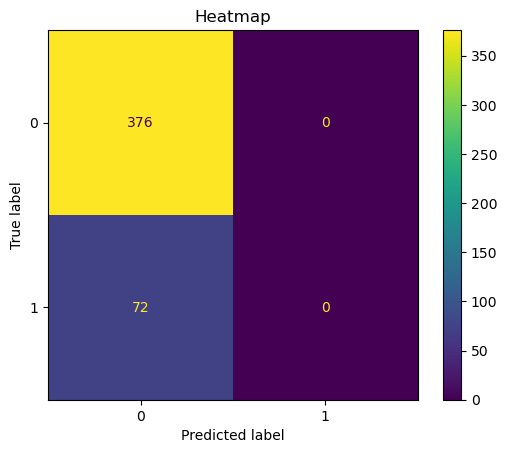

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: Neighbours...
Score on training data: 0.8610491071428571
Score on valid data: 0.8258928571428571
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       376
           1       0.25      0.04      0.07        72

    accuracy                           0.83       448
   macro avg       0.55      0.51      0.49       448
weighted avg       0.75      0.83      0.77       448



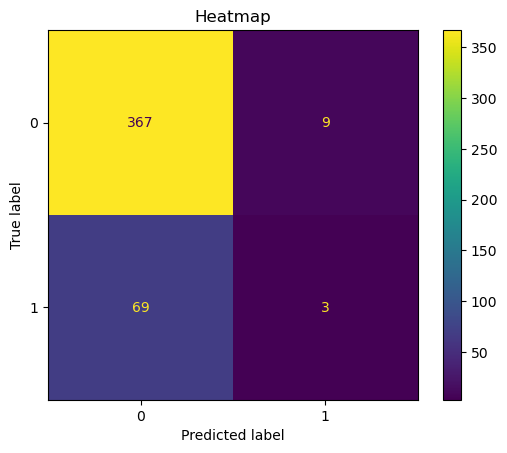

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: SGD...
Score on training data: 0.8537946428571429
Score on valid data: 0.8392857142857143
Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       376
           1       0.00      0.00      0.00        72

    accuracy                           0.84       448
   macro avg       0.42      0.50      0.46       448
weighted avg       0.70      0.84      0.77       448



D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


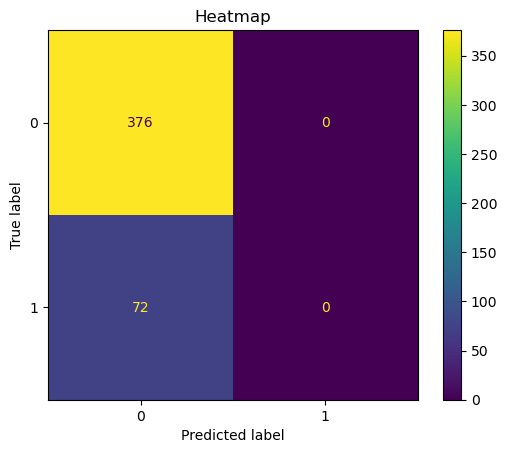

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: DecisionTree...
Score on training data: 1.0
Score on valid data: 0.7566964285714286
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       376
           1       0.24      0.24      0.24        72

    accuracy                           0.76       448
   macro avg       0.55      0.55      0.55       448
weighted avg       0.76      0.76      0.76       448



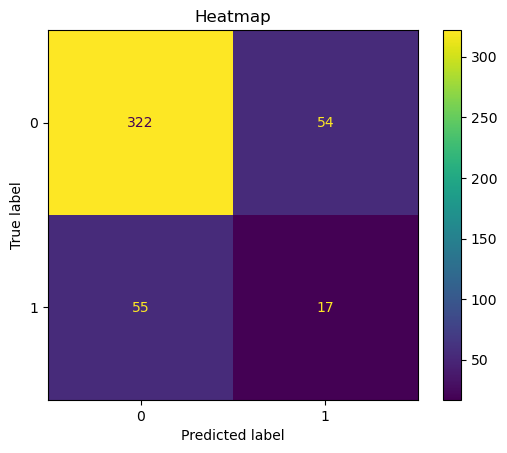

----------------------------------------------------------------------



{'Logistic Regression': LogisticRegression(max_iter=5000),
 'RandomForestClassifier': RandomForestClassifier(),
 'LinearSVC': LinearSVC(),
 'SVC': SVC(max_iter=10000),
 'Neighbours': KNeighborsClassifier(),
 'SGD': SGDClassifier(),
 'DecisionTree': DecisionTreeClassifier()}

In [199]:
np.random.seed(42)
evaluate_model(models_dict, X_train, y_train, X_test, y_test)

### Quick note

From above metrics we can see that the main problem is that our data is unbalanced.  
Let's try to use oversampling in order to gain more accuracy.
   
Let's divide whole data and create train, valid and test datasets.  

In [200]:
customers_data = pd.read_csv("superstore_data.csv",
                             parse_dates = ["Dt_Customer"])

In [201]:
df_temp = customers_data

In [202]:
df_temp = format_data(df_temp)
X = df_temp.drop("Response", axis = 1)
y = df_temp["Response"]

X_resampled, y_resampled = RandomOverSampler().fit_resample(X, y)
X_resampled = StandardScaler().fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

----------------------------------------------------------------------
Processing: Logistic Regression...
Score on training data: 0.7757957327736971
Score on valid data: 0.7481636935991606
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       489
           1       0.73      0.76      0.75       464

    accuracy                           0.75       953
   macro avg       0.75      0.75      0.75       953
weighted avg       0.75      0.75      0.75       953



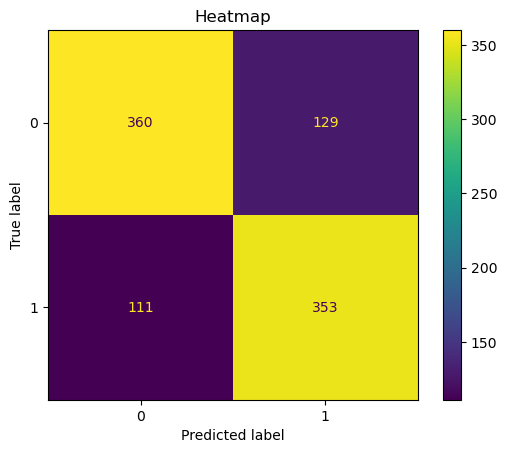

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: RandomForestClassifier...
Score on training data: 1.0
Score on valid data: 0.9706190975865687
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       489
           1       0.94      1.00      0.97       464

    accuracy                           0.97       953
   macro avg       0.97      0.97      0.97       953
weighted avg       0.97      0.97      0.97       953



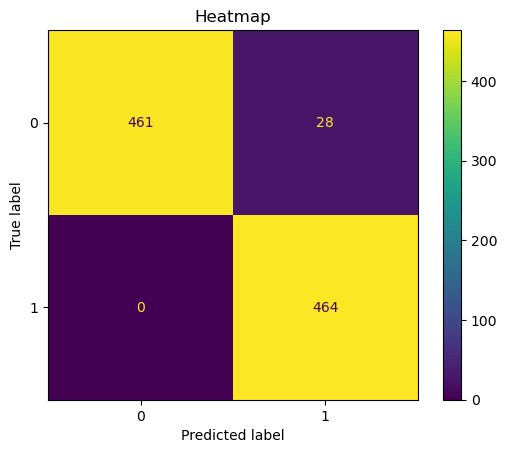

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: LinearSVC...
Score on training data: 0.7674011892270024
Score on valid data: 0.7397691500524659
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       489
           1       0.73      0.74      0.74       464

    accuracy                           0.74       953
   macro avg       0.74      0.74      0.74       953
weighted avg       0.74      0.74      0.74       953



D:\ProgramingALL\ClassificationProject\env\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


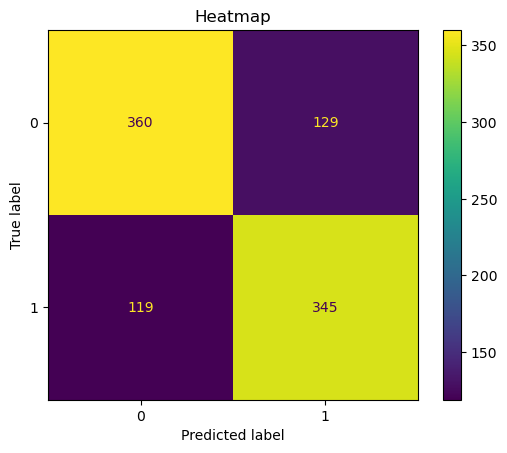

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: SVC...
Score on training data: 0.9108079748163693
Score on valid data: 0.8551941238195173
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       489
           1       0.81      0.91      0.86       464

    accuracy                           0.86       953
   macro avg       0.86      0.86      0.86       953
weighted avg       0.86      0.86      0.85       953



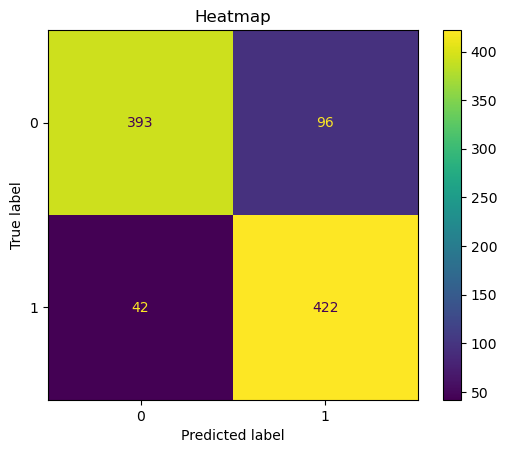

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: Neighbours...
Score on training data: 0.9062609303952431
Score on valid data: 0.8604407135362014
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       489
           1       0.80      0.96      0.87       464

    accuracy                           0.86       953
   macro avg       0.87      0.86      0.86       953
weighted avg       0.88      0.86      0.86       953



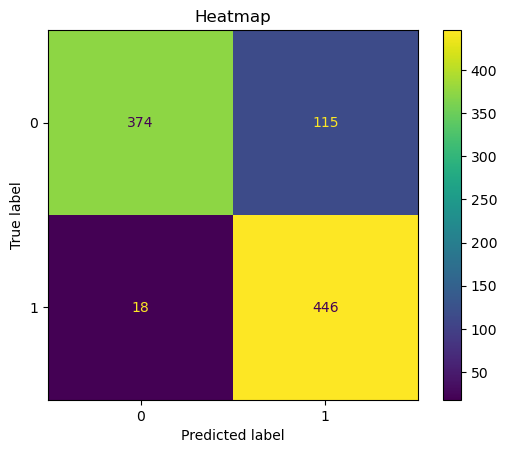

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: SGD...
Score on training data: 0.7040923399790137
Score on valid data: 0.6789087093389297
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       489
           1       0.68      0.64      0.66       464

    accuracy                           0.68       953
   macro avg       0.68      0.68      0.68       953
weighted avg       0.68      0.68      0.68       953



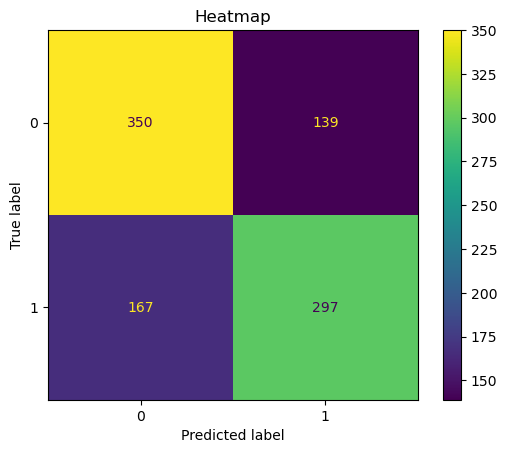

----------------------------------------------------------------------

----------------------------------------------------------------------
Processing: DecisionTree...
Score on training data: 1.0
Score on valid data: 0.9391395592864638
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       489
           1       0.89      1.00      0.94       464

    accuracy                           0.94       953
   macro avg       0.94      0.94      0.94       953
weighted avg       0.95      0.94      0.94       953



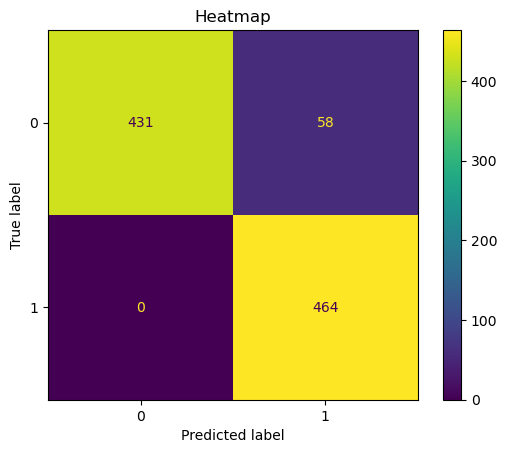

----------------------------------------------------------------------



In [203]:
np.random.seed(1)
model_to_save = evaluate_model(models_dict, X_train, y_train, X_test, y_test)

# Feature importances from the best model (RFC)

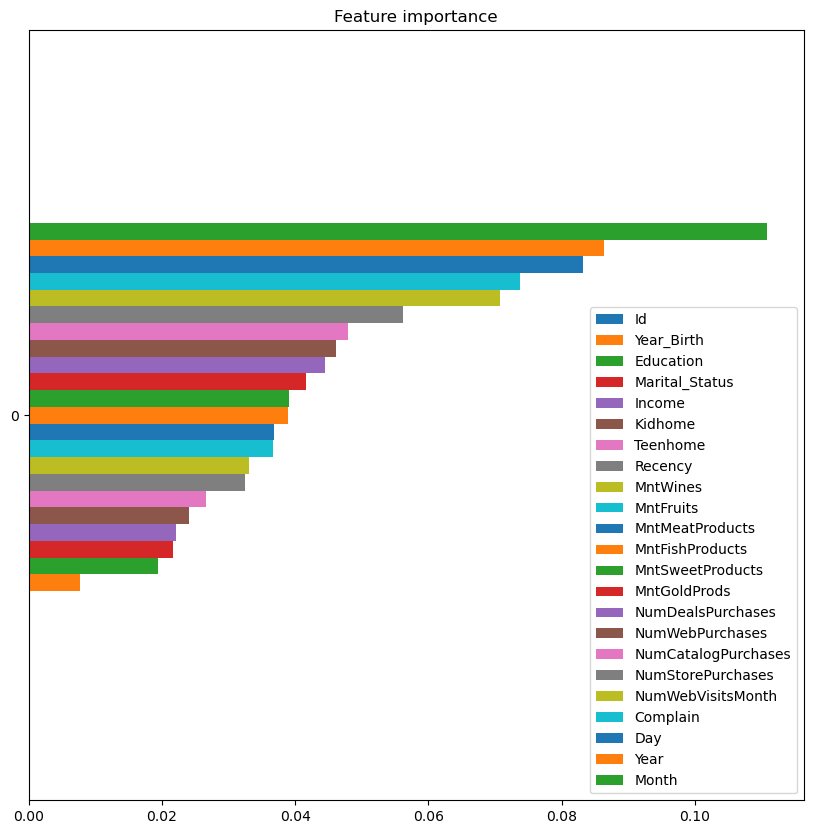

In [204]:
feature_importances = pd.DataFrame(np.sort(model_to_save["RandomForestClassifier"].feature_importances_), index = X.columns)
feature_importances.T.plot.barh(figsize = (10, 10))
plt.title("Feature importance");

# Saving model

In [205]:
save_model(model_to_save["RandomForestClassifier"], "RandomForestClassifier97")

## Quick note

We didn't have to tune our hyperparameters because our model reached very good accuracy.